# Reproducing Brian Blaylock's .ipynb

Brian Blaylock, an atmospheric science PhD candidate at University of Utah, has some great examples of using Python tools to work with GOES-16 data. He is using I am going to try to use his work as a starting point to create some plots of our AOD data.

## Goal

The goal of this notebook is simply to successfully set up our environment, copy Brian Blaylock's code from [one of his notebooks][blaylock-cartopy-link] and get it running. I have created a text file with the information needed to create a conda environment that this notebook runs in. Instructions for building the environment are in the README.md, but if you are reading this you've likely figured all of that out already!

[blaylock-cartopy-link]:(https://github.com/blaylockbk/pyBKB_v3/blob/master/BB_GOES/mapping_GOES16_TrueColor_Cartopy.ipynb)

If the environment is set up correctly, all of the following cells should run!

In [10]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

In [11]:
######################################################################
# Open the GOES-16 NetCDF File
# ----------------------------
# Using xarray, I assign the opened file to the variable C for the CONUS domain.
BASEPATH = '../../local_data/'
FILE = 'OR_ABI-L2-MCMIPC-M3_G16_s20190881302160_e20190881304533_c20190881305044.nc'

C = xarray.open_dataset(BASEPATH+FILE)

In [12]:
######################################################################
# Date and Time Information
# ----------------------------
# Each file represents the data collected during one scan sequence for the
# domain. There are several different time stamps in this file, which are also
# found in the file's name.

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

print('Scan Start    : %s' % scan_start)
print('Scan midpoint : %s' % scan_mid)
print('Scan End      : %s' % scan_end)
print('File Created  : %s' % file_created)
print('Scan Duration : %.2f minutes' % ((scan_end-scan_start).seconds/60))

Scan Start    : 2019-03-29 13:02:16
Scan midpoint : 2019-03-29 13:03:34.600000
Scan End      : 2019-03-29 13:04:53.300000
File Created  : 2019-03-29 13:05:04.400000
Scan Duration : 2.62 minutes


In [13]:
######################################################################
# True Color Recipe
# -----------------
#
# Color images are a Red-Green-Blue (RGB) composite of three different
# channels. We will assign the following channels as our RGB values:
#
#
# RGB values must be between 0 and 1, same as the range of values of the
# reflectance channels. A gamma correction is applied to control the brightness
# and make the image not look too dark where `corrected_value =
# value^(1/gamma)`. Most displays have a decoding gamma of 2.2
# ([source1](https://en.wikipedia.org/wiki/Gamma_correction),
# [source2](https://www.cambridgeincolour.com/tutorials/gamma-correction.htm)).
#
# The GREEN "veggie" channel on GOES-16 does not measure visible green
# light. Instead, it measures a near-infrared band sensitive to chlorophyll. We
# could use that channel in place of green, but it would make the green in our
# image appear too vibrant. Instead, we will tone-down the green channel by
# interpolating the value to simulate a natural green color.
#
# \begin{equation}
# TrueGreen = (0.48358168*RED) + (0.06038137*GREEN) + (0.45706946*BLUE)
# \end{equation}
#
# or, a simple alternative ([CIMSS Natural True
# Color](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf)):
#
# \begin{equation}
# TrueGreen = (0.45*RED) + (0.1*GREEN) + (0.45*BLUE)
# \end{equation}
#
# The multiband formatted file we loaded is convenient becuase all the GOES
# channels are in the same NetCDF file. Next, we will assign our variables R, G,
# and B as the data for each channel.


# Confirm that each band is the wavelength we are interested in
for band in [2, 3, 1]:
    print("%s is %.2f %s" % (C['band_wavelength_C%02d' % band].long_name,
                             C['band_wavelength_C%02d' % band][0],
                             C['band_wavelength_C%02d' % band].units))

######################################################################
#

# Load the three channels into appropriate R, G, and B variables
R = C['CMI_C02'].data
G = C['CMI_C03'].data
B = C['CMI_C01'].data

######################################################################
#

# Apply range limits for each channel. RGB values must be between 0 and 1
R = np.clip(R, 0, 1)
G = np.clip(G, 0, 1)
B = np.clip(B, 0, 1)

######################################################################
#

# Apply a gamma correction to the image
gamma = 2.2
R = np.power(R, 1/gamma)
G = np.power(G, 1/gamma)
B = np.power(B, 1/gamma)

######################################################################
#

# Calculate the "True" Green
G_true = 0.45 * R + 0.1 * G + 0.45 * B
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.87 um
ABI band 1 central wavelength is 0.47 um


/anaconda3/envs/goes16aod/lib/python3.5/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in maximum
/anaconda3/envs/goes16aod/lib/python3.5/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in minimum


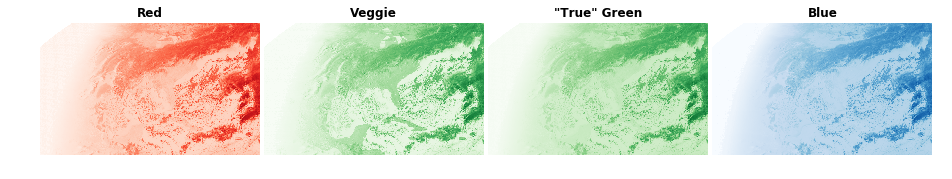

In [14]:
######################################################################
# Simple Image
# -----------------
#
# Use `plt.imshow` to get a quick look at the channels and RGB composite we
# created.
#
# First, we plot each channel individually. The deeper the color means the
# satellite is observing more light in that channel. Clouds appear white becuase
# they reflect lots of red, green, and blue light. You will also notice that the
# land reflects a lot of "green" in the veggie channel becuase this channel is
# sensitive to the chlorophyll.

fig, ([ax1, ax2, ax3, ax4]) = plt.subplots(1, 4, figsize=(16, 3))

ax1.imshow(R, cmap='Reds', vmax=1, vmin=0)
ax1.set_title('Red', fontweight='semibold')
ax1.axis('off')a

ax2.imshow(G, cmap='Greens', vmax=1, vmin=0)
ax2.set_title('Veggie', fontweight='semibold')
ax2.axis('off')

ax3.imshow(G_true, cmap='Greens', vmax=1, vmin=0)
ax3.set_title('"True" Green', fontweight='semibold')
ax3.axis('off')

ax4.imshow(B, cmap='Blues', vmax=1, vmin=0)
ax4.set_title('Blue', fontweight='semibold')
ax4.axis('off')

plt.subplots_adjust(wspace=.02)

(-0.5, 2499.5, 1499.5, -0.5)

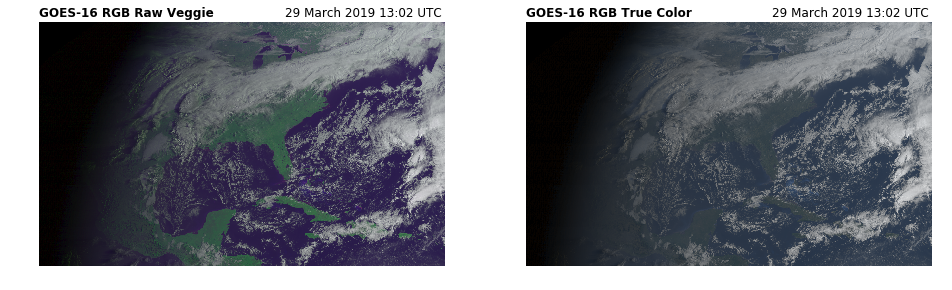

In [15]:
######################################################################
# The addition of the three channels results in a color image. We combine the
# three channels in a stacked array and display the image with `imshow` again.
#

# The RGB array with the raw veggie band
RGB_veggie = np.dstack([R, G, B])

# The RGB array for the true color image
RGB = np.dstack([R, G_true, B])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(RGB_veggie)
ax1.set_title('GOES-16 RGB Raw Veggie', fontweight='semibold', loc='left', fontsize=12);
ax1.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax1.axis('off')

# The RGB for the true color image
ax2.imshow(RGB)
ax2.set_title('GOES-16 RGB True Color', fontweight='semibold', loc='left', fontsize=12);
ax2.set_title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');
ax2.axis('off')

In [16]:
######################################################################
# Plot with `Cartopy`:  Geostationary Projection
# ----------------------------------------------
# 
# The image above is not georeferenced. You can see the land and oceans, but we
# do have enough information to draw state and country boundaries. From the
# GOES-16 file, we can extract all the metadata needed to understand the map
# projection. We will use this data to plot the image on a `Basemap`. The image
# is in a [geostationary
# projection](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

C['goes_imager_projection']

######################################################################
#

# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

semi_major = C['goes_imager_projection'].semi_major_axis
semi_minor = C['goes_imager_projection'].semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

In [17]:
C['x'][0:10]

<xarray.DataArray 'x' (x: 10)>
array([-0.101332, -0.101276, -0.10122 , -0.101164, -0.101108, -0.101052,
       -0.100996, -0.10094 , -0.100884, -0.100828], dtype=float32)
Coordinates:
    t        datetime64[ns] 2019-03-29T13:03:34.691270912
  * x        (x) float32 -0.101332 -0.101276 -0.10122 ... -0.100884 -0.100828
    y_image  float32 ...
    x_image  float32 ...
Attributes:
    units:          rad
    axis:           X
    long_name:      GOES fixed grid projection x-coordinate
    standard_name:  projection_x_coordinate

/anaconda3/envs/goes16aod/lib/python3.5/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/anaconda3/envs/goes16aod/lib/python3.5/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


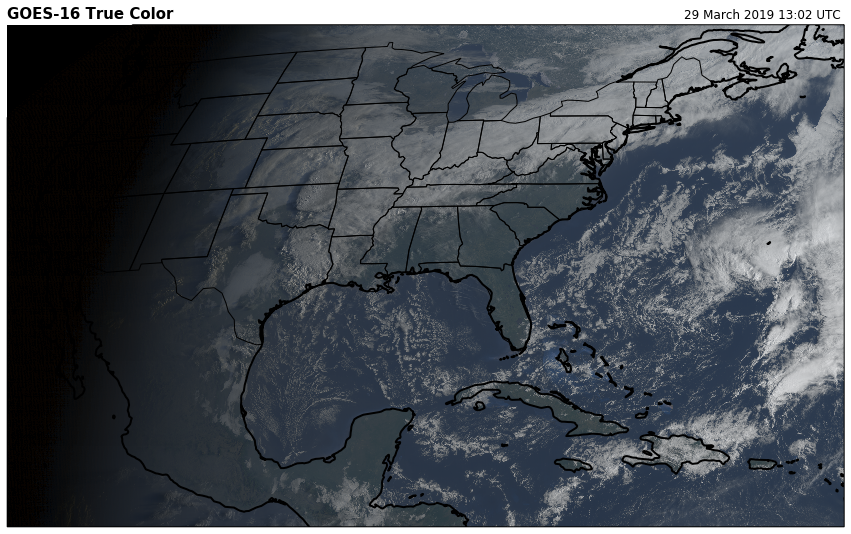

In [9]:
######################################################################
# The geostationary projection is the easiest way to plot the image on a
# map. Essentially, we are stretching the image across a map with the same
# projection and dimensions as the data.

fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(np.flipud(RGB), origin='lower',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='nearest', vmin=162., vmax=330.)
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

plt.title('GOES-16 True Color', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');

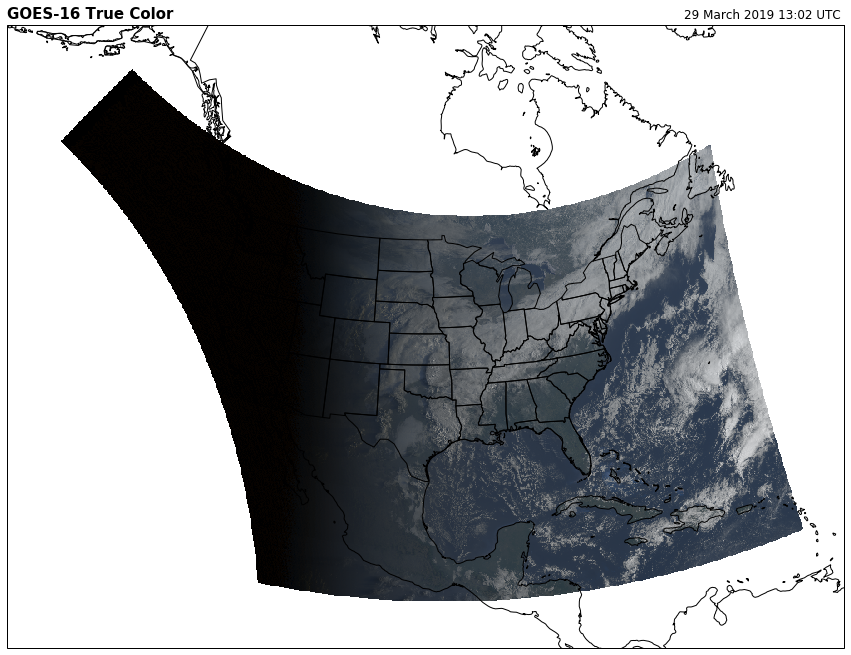

In [10]:
######################################################################
# Using other projections
# ----------------------------------------------
#
# Changing the projections with cartopy is straightforward. Here we use
# the Lambert Conformal projection to display the GOES-16 data.

fig = plt.figure(figsize=(15, 12))

lc = ccrs.LambertConformal(central_longitude=-97.5,standard_parallels=(38.5,38.5))

ax = fig.add_subplot(1, 1, 1, projection=lc)
ax.set_extent([-135, -60, 10, 65], crs=ccrs.PlateCarree())

ax.imshow(np.flipud(RGB), origin='lower',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='none')
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.STATES)

plt.title('GOES-16 True Color', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right');